In [1]:
import os

import cv2
import numpy as np
from matplotlib import pyplot as plt
import albumentations as A
from tifffile import imread
from random import randint

import segmentation_models_pytorch as smp
import torch
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset as BaseDataset, random_split

from pprint import pprint 

In [2]:
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")


GPU: NVIDIA GeForce GTX 1660 SUPER is available.


In [42]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

# Import dataset

In [31]:

proj_uri = r'D:\NSC2024\QuPath_proj'

# images = np.memmap(proj_uri+'/memmap/images.mymemmap', dtype=np.uint8, mode='w+', shape=(1, 0))
# masks = np.memmap(proj_uri+'/memmap/masks.mymemmap', dtype=np.uint8, mode='w+', shape=(1, 0))
images = []
masks = []

export_uri = r'D:\NSC2024\QuPath_proj\export'
# export_uri = r'D:\OneDrive-CMU\Desktop_Dell\QuPath\export'

for base_uri in os.listdir(export_uri):
    for root, subdirs, files in os.walk(os.path.join(export_uri, base_uri, 'images')):
        for file in files:
            file_path = os.path.join(root, file)
            image = imread(file_path)

            images.append(image)
    
    for root, subdirs, files in os.walk(os.path.join(export_uri, base_uri, 'masks')):
        for file in files:
            file_path = os.path.join(root, file)
            mask = imread(file_path)

            masks.append(mask)

images = np.asarray(images)
masks = np.asarray(masks)

N = len(images)

print(images.shape)
print(masks.shape)
print(np.unique(masks))

(80, 512, 512, 3)
(80, 3, 512, 512)
[  0 255]


In [32]:
N = len(images)
SIZE = images.shape[-2]
n_classes = 3

print(N, SIZE, n_classes)

80 512 3


# Process dataset

##### Convert labels' index

In [33]:
for i in range(N):
    for c in range(n_classes):
        masks[i][c][masks[i][c] == 255] = 1

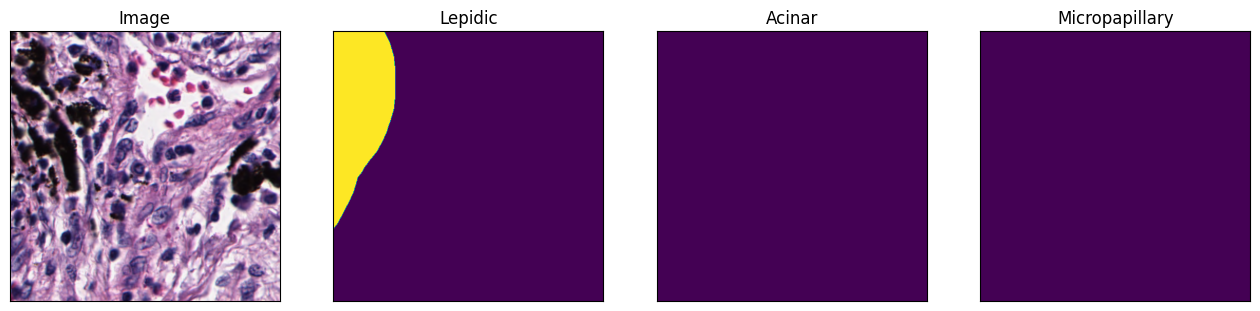

[0 1]


In [53]:
r = randint(0, len(images) - 1)

visualize(image=images[r], lepidic=masks[r][0], acinar=masks[r][1], micropapillary=masks[r][2])

print(np.unique(masks[r]))

In [ ]:
from sklearn.model_selection import train_test_split

# split dataset into train, test, and validation
x_train, x_test, y_train, y_test = train_test_split(images, masks, test_size=0.6, random_state=0)
x_train, x_val, y_train, y_val = train_test_split(images, masks, test_size=0.5, random_state=0)

In [ ]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. normalization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['lepidic', 'acinar', 'micropapillary']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

In [ ]:
dataset = Dataset(x_train_dir, y_train_dir, classes=['car'])

image, mask = os.path.join(export_uri, '')
visualize(
    image=image, 
    cars_mask=mask.squeeze(),
)

# Model Setup

In [ ]:
class Model(pl.LightningModule):

    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        )

        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.MULTILABEL_MODE, ignore_index=0, from_logits=True)

    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        
        image = batch["image"]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32, 
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of 
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have 
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["mask"]

        # Shape of the mask should be [batch_size, num_classes, height, width]
        # for binary segmentation num_classes = 1
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)
        
        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then 
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image 
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        
        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset 
        # with "empty" images (images without target class) a large gap could be observed. 
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }
        
        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")            

    def training_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def validation_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")  

    def test_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

In [ ]:
model = Model("Unet", "resnet34", in_channels=3, out_classes=3)

# Training

In [10]:
loss = smp.losses.DiceLoss(mode='multilabel')
metrics = [
    smp.metrics.functional.iou_score(),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

NameError: name 'model' is not defined

In [2]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to C:\Users\USER/.cache\torch\hub\checkpoints\resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:25<00:00, 3.37MB/s]


In [ ]:
from segmentation_models_pytorch.encoders import get_preprocessing_fn

preprocess_input = get_preprocessing_fn('resnet18', pretrained='imagenet')

for images, gt_masks in dataloader:

    predicted_mask = model(image)
    loss = loss_fn(predicted_mask, gt_masks)

    loss.backward()
    optimizer.step()


In [ ]:
import keras

activation='softmax'
LR = 0.0001
opt = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.25, 0.25, 0.25, 0.25])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [ ]:
BACKBONE = 'resnet101'

# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation=activation)

# compile keras model with defined optimizer, loss and metrics
model.compile(opt, total_loss, metrics=metrics)

# model.summary()

In [ ]:
preprocess_input = sm.get_preprocessing(BACKBONE)
pre_x_train = preprocess_input(x_train)
pre_x_val = preprocess_input(x_val)

# history = model.fit(pre_x_train, 
#           y_train_cat,
#           validation_data=(pre_x_val, y_val_cat),
#           batch_size=2, 
#           verbose=2,
#           epochs=20
#           )

# model.save('test.keras')

In [ ]:
from keras.models import load_model

model = load_model('./test.keras', compile=False)

In [ ]:
pre_x_test = preprocess_input(x_test)
y_pred = model.predict(pre_x_test)
y_pred_argmax = np.argmax(y_pred, axis=3)

In [ ]:
y_pred_argmax.shape
np.unique(y_pred_argmax)
y_test[y_test == -1] = 0

In [ ]:
from keras.metrics import MeanIoU

IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

In [ ]:
def gray_to_rgb(x):
    x_reshaped = np.concatenate([x] * 3, axis=-1)
    color_map = {
            1: [255, 0, 0],   # Red for label 1
            2: [0, 255, 0],   # Green for label 2
            3: [0, 0, 255]    # Blue for label 3
        }
    
    rgb = np.zeros_like(x_reshaped, dtype=np.uint8)
    for label, color in color_map.items():
            rgb[x_reshaped[..., 0] == label] = color 
    return rgb


In [ ]:
"""
    1 - Lepidic: RED
    2 - Arcinar: GREEN
    3 - Micropapillary: BLUE
"""

y_test_show_rgb = gray_to_rgb(y_test)

y_pred_argmax = np.expand_dims(y_pred_argmax, axis=-1)
y_pred_argmax_show_rgb = gray_to_rgb(y_pred_argmax)


In [ ]:
idx = randint(0, len(x_test)-1)
# idx = 19

fig, axs = plt.subplots(1, 3, figsize=(10, 5))
print(y_test.shape)
print("Index: ", idx)

axs[0].imshow(x_test[idx])
axs[0].set_title("source")
axs[0].axis('off')

axs[1].imshow(y_test_show_rgb[idx], cmap='gray')
axs[1].set_title("ground truth")
axs[1].axis('off')

axs[2].imshow(y_pred_argmax_show_rgb[idx], cmap='gray')
axs[2].set_title("predict")
axs[2].axis('off')

np.unique(y_pred_argmax[idx])